In [4]:
%matplotlib inline
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import IPython.display as ipd

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [5]:
musicdf = pd.read_csv('./musicdf30.csv', index_col=0, encoding='latin-1')

In [6]:
musicdf.columns

Index(['composer', 'description', 'symphony', 'file', 'part', 'tempo', 'bpm',
       'duration', 'zero_crossings', 'spectral_centroid_avg',
       'spectral_bw_avg', 'Chroma_A', 'Chroma_A#', 'Chroma_B', 'Chroma_C',
       'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E', 'Chroma_F',
       'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'MFCC_0', 'MFCC_1', 'MFCC_10',
       'MFCC_11', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7',
       'MFCC_8', 'MFCC_9', 'MFCC_SD_0', 'MFCC_SD_1', 'MFCC_SD_10',
       'MFCC_SD_11', 'MFCC_SD_2', 'MFCC_SD_3', 'MFCC_SD_4', 'MFCC_SD_5',
       'MFCC_SD_6', 'MFCC_SD_7', 'MFCC_SD_8', 'MFCC_SD_9', 'Chroma_SD_A',
       'Chroma_SD_A#', 'Chroma_SD_B', 'Chroma_SD_C', 'Chroma_SD_C#',
       'Chroma_SD_D', 'Chroma_SD_D#', 'Chroma_SD_E', 'Chroma_SD_F',
       'Chroma_SD_F#', 'Chroma_SD_G', 'Chroma_SD_G#'],
      dtype='object')

In [ ]:
#Not using the Tempo labels. I am not sure if it adds any value
#musicdf = pd.concat([musicdf, pd.get_dummies(musicdf['tempo'],  drop_first=True)], axis=1)

In [7]:
# Subset of columns that would be used for clustering
feature_cols = musicdf.columns.drop(['composer', 'description', 'symphony', 'tempo', 'file', 'part', 'duration']
#                                    + ['zero_crossings']
+ ['MFCC_0', 'MFCC_1', 'MFCC_10', 'MFCC_11', 'MFCC_2', 'MFCC_3', 'MFCC_4',
       'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_SD_0',
       'MFCC_SD_1', 'MFCC_SD_10', 'MFCC_SD_11', 'MFCC_SD_2', 'MFCC_SD_3',
       'MFCC_SD_4', 'MFCC_SD_5', 'MFCC_SD_6', 'MFCC_SD_7', 'MFCC_SD_8',
       'MFCC_SD_9']);
#+ ['Chroma_A', 'Chroma_A#', 'Chroma_B', 'Chroma_C', 'Chroma_C#',
#       'Chroma_D', 'Chroma_D#', 'Chroma_E', 'Chroma_F', 'Chroma_F#',
#       'Chroma_G', 'Chroma_G#', 'Chroma_SD_A', 'Chroma_SD_A#', 'Chroma_SD_B',
#       'Chroma_SD_C', 'Chroma_SD_C#', 'Chroma_SD_D', 'Chroma_SD_D#',
#       'Chroma_SD_E', 'Chroma_SD_F', 'Chroma_SD_F#', 'Chroma_SD_G',
#       'Chroma_SD_G#'])

In [8]:
feature_cols

Index(['bpm', 'zero_crossings', 'spectral_centroid_avg', 'spectral_bw_avg',
       'Chroma_A', 'Chroma_A#', 'Chroma_B', 'Chroma_C', 'Chroma_C#',
       'Chroma_D', 'Chroma_D#', 'Chroma_E', 'Chroma_F', 'Chroma_F#',
       'Chroma_G', 'Chroma_G#', 'Chroma_SD_A', 'Chroma_SD_A#', 'Chroma_SD_B',
       'Chroma_SD_C', 'Chroma_SD_C#', 'Chroma_SD_D', 'Chroma_SD_D#',
       'Chroma_SD_E', 'Chroma_SD_F', 'Chroma_SD_F#', 'Chroma_SD_G',
       'Chroma_SD_G#'],
      dtype='object')

In [9]:
musicdf.shape

(61, 59)

In [10]:
df = musicdf[feature_cols]

In [11]:
df.shape

(61, 28)

In [12]:
## https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
df.is_copy = False

In [13]:
## Scalng for k-nearest neighbours
## Scale the features (using the scale function) from -1 to 1.
#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
#df[feature_cols] = min_max_scaler.fit_transform(df)
#http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
df[feature_cols] = preprocessing.StandardScaler().fit_transform(df[feature_cols])

In [14]:
df.head()

,bpm,zero_crossings,spectral_centroid_avg,spectral_bw_avg,Chroma_A,Chroma_A#,Chroma_B,Chroma_C,Chroma_C#,Chroma_D,...,Chroma_SD_B,Chroma_SD_C,Chroma_SD_C#,Chroma_SD_D,Chroma_SD_D#,Chroma_SD_E,Chroma_SD_F,Chroma_SD_F#,Chroma_SD_G,Chroma_SD_G#
0,-0.293897,-1.180141,0.068880,0.887257,1.341396,0.442128,-1.103446,-0.983774,0.158718,-0.596200,...,1.262277,1.743599,1.776464,2.120272,0.210404,1.876112,0.571282,-0.877557,-2.074283,1.042359
1,-0.293897,-1.118018,-0.873084,-0.008647,0.751337,0.204818,-0.810637,-1.188572,1.149090,1.563927,...,1.993880,0.259685,0.330945,1.470322,-0.241651,0.740272,0.271956,1.332379,-0.470211,1.151025
2,-0.416703,-0.581697,1.011198,2.038851,-1.312636,-0.064678,1.843617,0.643285,-1.005027,-0.862369,...,1.062708,-0.283381,-0.492948,0.347979,0.400544,0.282459,-0.823221,0.294371,-0.831604,-0.523833
3,-0.646297,-0.639386,0.181621,0.066358,-0.455925,0.018834,0.175453,-0.213685,1.089417,2.014804,...,0.953879,1.150526,0.177549,1.287415,0.415480,-0.294859,-0.354581,0.610085,0.598412,0.137836
4,-0.293897,-1.073563,-0.538791,-0.469352,1.014053,2.376781,0.895647,-2.596445,-1.213412,1.262394,...,-0.645527,-1.520113,-0.986839,-1.357758,-2.036364,-1.223419,-0.470787,-0.304585,0.585820,-0.239144


In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(df)[:,0]
Y = pca.fit_transform(df)[:,1]
#Z = pca.fit_transform(df)[:,2]

In [19]:
df['x'] = X
df['y'] = Y
#df['z'] = Z

Elbow curve to determine the right number of clusters

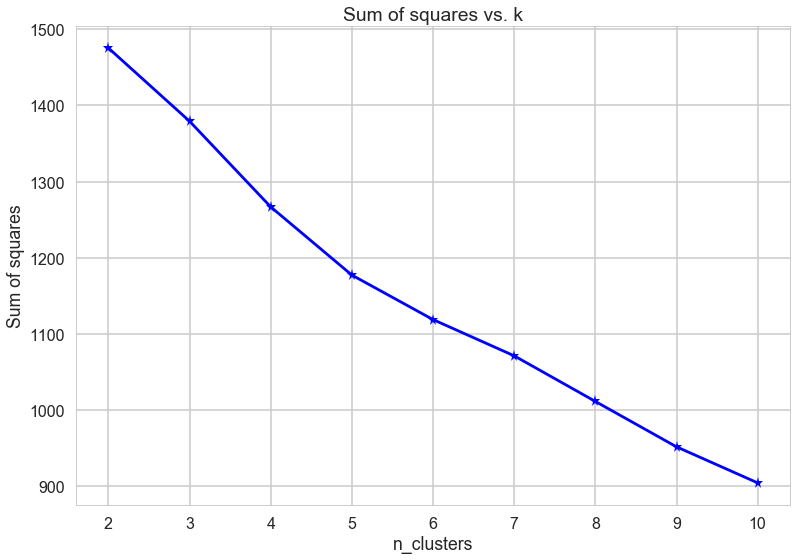

In [17]:
k_range = range(2,11)
k_means_var = [sklearn.cluster.KMeans(n_clusters=k, random_state=10).fit(df[feature_cols]) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]
from scipy.spatial import distance
k_euclid = [distance.cdist(df[feature_cols], cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, wcss, 'b*-')
#ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('n_clusters')
plt.ylabel('Sum of squares')
plt.title('Sum of squares vs. k')

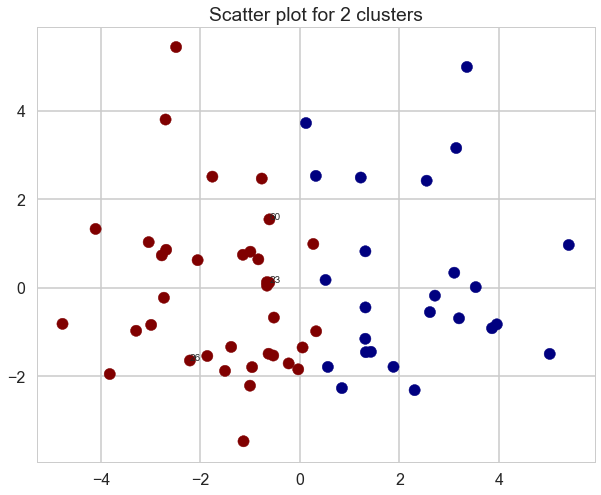

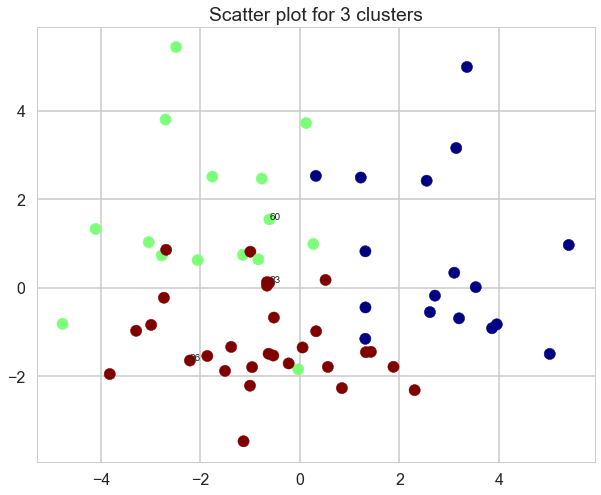

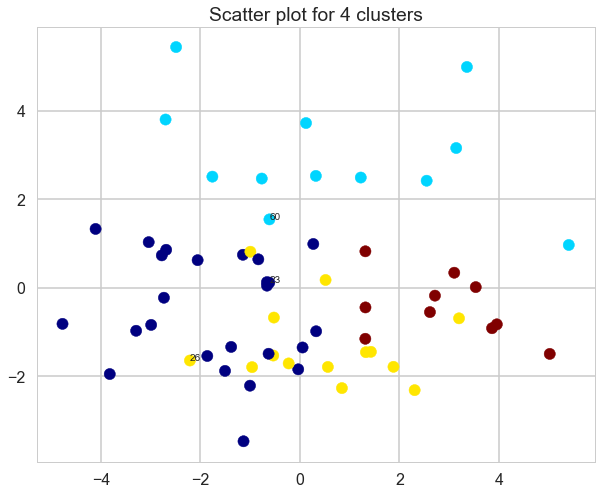

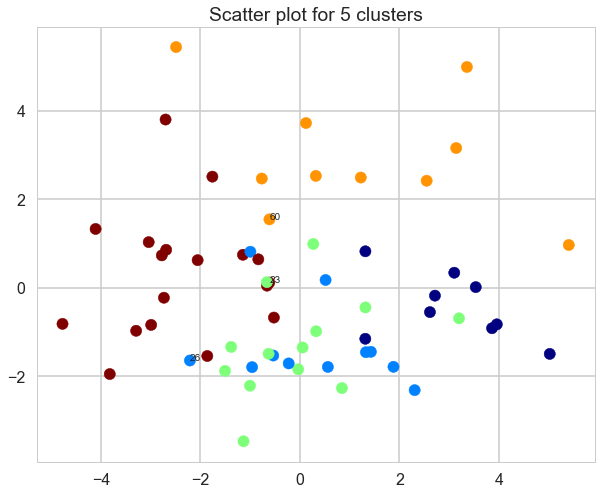

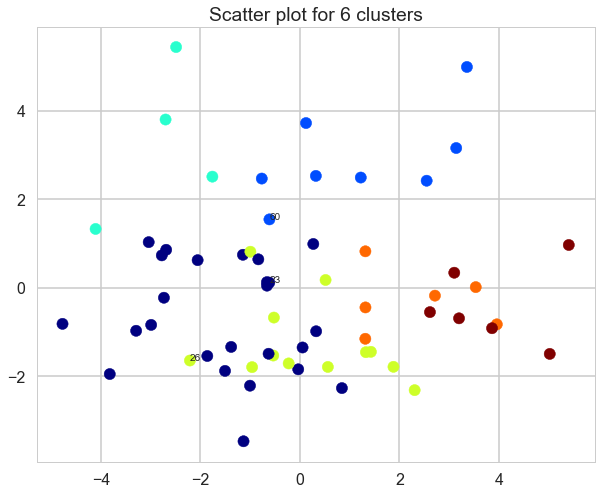

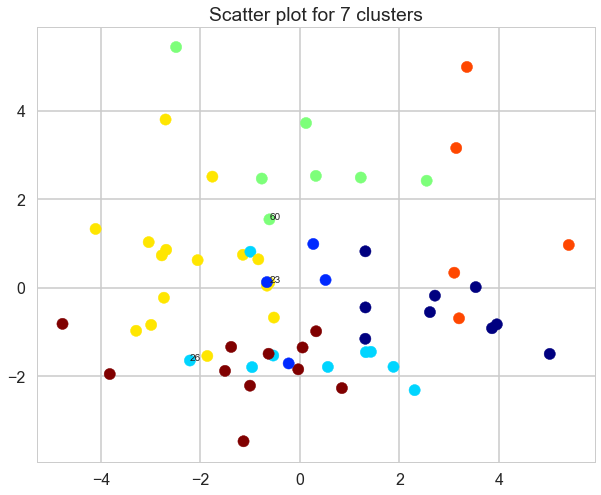

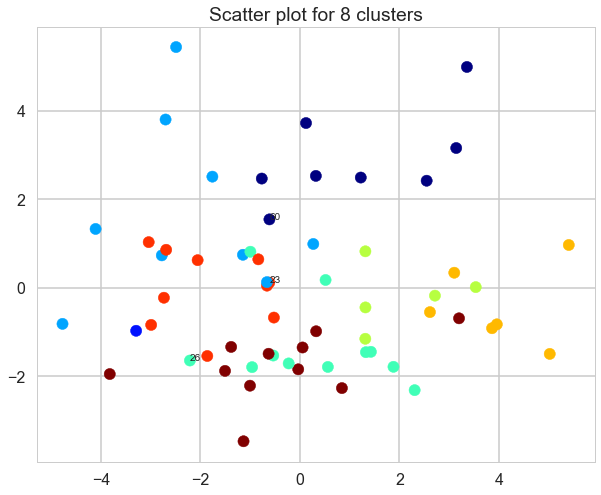

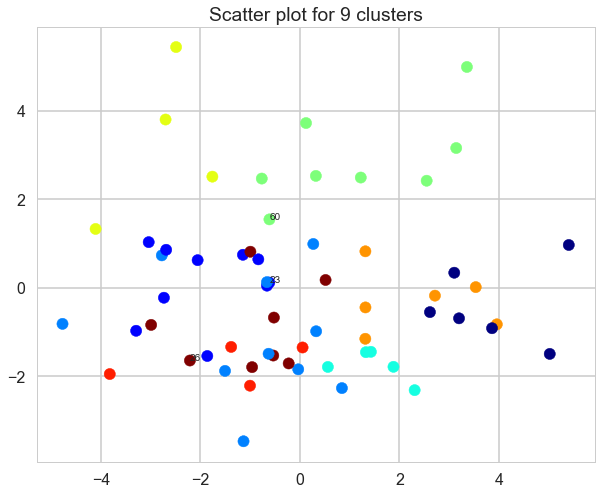

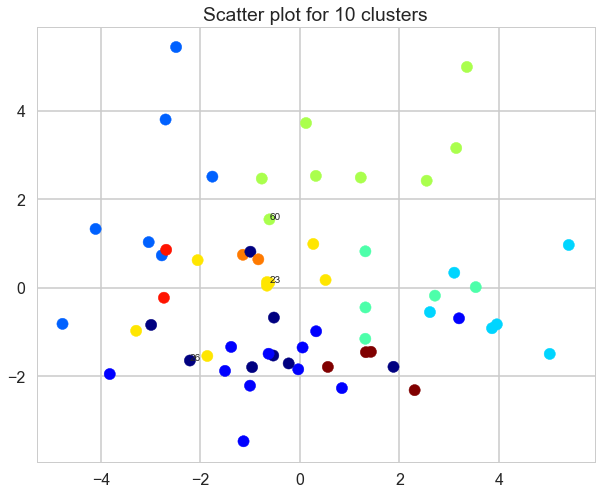

In [20]:
%matplotlib inline
k_range = range(2,11)
for n_clusters in k_range:
    kmeanscluster = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    df['cluster'] = kmeanscluster.fit_predict(df[feature_cols])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    fig.set_size_inches(10, 8)
    ax1.scatter(df['x'],df['y'],c=df['cluster'], cmap='jet')
    ax1.set_title("Scatter plot for %d clusters"%n_clusters)
    for i in [60,26,23]:
        ax1.annotate(i, (df['x'][i],df['y'][i]))
    plt.show()
    del df['cluster']

In [21]:
kmeanscluster = sklearn.cluster.KMeans(n_clusters=5, random_state=10)
df['cluster'] = kmeanscluster.fit_predict(df[feature_cols])

In [ ]:
#kmeanscluster.cluster_centers_

In [22]:
kmeanscluster.labels_

array([4, 4, 2, 4, 1, 2, 2, 1, 0, 3, 3, 0, 3, 1, 2, 0, 2, 1, 0, 4, 4, 2, 4,
       4, 1, 1, 1, 1, 3, 3, 3, 0, 4, 0, 4, 3, 4, 4, 4, 1, 2, 2, 2, 1, 1, 4,
       4, 3, 2, 0, 4, 4, 3, 4, 0, 4, 2, 0, 2, 2, 3])

In [23]:
df = pd.concat([df, pd.DataFrame(kmeanscluster.fit_transform(df[feature_cols]).tolist(),  columns=['cluster_a','cluster_b', 'cluster_c', 'cluster_d', 'cluster_e'])], axis=1)

In [24]:
df.rename(columns={0: 'cluster'}, inplace=True)

In [ ]:
## Tried the Affinity propogation method but then decided not to use the eight clusters suggested by it.
#model = sklearn.cluster.AffinityPropagation()
#labels = model.fit_predict(df[feature_cols])
#print(labels)

In [25]:
df['cluster_dist'] = df.loc[:, ['cluster_a', 'cluster_b', 'cluster_c', 'cluster_d', 'cluster_e']].min(axis=1)

In [26]:
df.groupby(['cluster']).agg({"cluster_dist": [min, max]})

cluster_dist          
                 min       max
cluster                       
0           3.336545  4.764158
1           2.256792  4.964188
2           2.445539  6.309407
3           3.180233  7.614865
4           3.224881  6.561071

In [27]:
clusters = df.groupby('cluster')

In [28]:
finalfive = pd.DataFrame(columns=musicdf.columns)
for name, group in clusters: 
    print(name)
    songs = musicdf.iloc[clusters.get_group(name).index]
    for index, row in songs.iterrows():
        print(row['composer']+' '+row['file'])
    print('')
    #finalfive = pd.concat([finalfive, musicdf.iloc[group.nsmallest(2, 'cluster_dist').index]])

0
albeniz alb_se3.mp3
albeniz alb_se6.mp3
bach bach_847.mp3
beethoven beethoven_opus10_1.mp3
beethoven waldstein_1.mp3
beethoven waldstein_3.mp3
borodin bor_ps3.mp3
brahms brahms_opus1_1.mp3
brahms brahms_opus1_4.mp3

1
albeniz alb_esp5.mp3
albeniz alb_se2.mp3
albeniz alb_se8.mp3
balak islamei.mp3
beethoven beethoven_opus22_1.mp3
beethoven beethoven_opus22_2.mp3
beethoven beethoven_opus22_3.mp3
beethoven beethoven_opus22_4.mp3
beethoven beethoven_les_adieux_3.mp3
beethoven beethoven_hammerklavier_1.mp3
beethoven beethoven_hammerklavier_2.mp3

2
albeniz alb_esp3.mp3
albeniz alb_esp6.mp3
albeniz alb_se1.mp3
bach bach_846.mp3
bach bach_850.mp3
beethoven pathetique_1.mp3
beethoven elise.mp3
beethoven beethoven_opus90_1.mp3
beethoven beethoven_opus90_2.mp3
borodin bor_ps2.mp3
brahms brahms_opus1_3.mp3
brahms br_im2.mp3
brahms br_im5.mp3

3
albeniz alb_se4.mp3
albeniz alb_se5.mp3
albeniz alb_se7.mp3
beethoven mond_1.mp3
beethoven mond_2.mp3
beethoven mond_3.mp3
beethoven appass_2.mp3
borodin

In [50]:
finalfive.file

29                       mond_2.mp3
9                       alb_se4.mp3
2                      alb_esp3.mp3
16                     bach_850.mp3
48                      bor_ps2.mp3
50                      bor_ps4.mp3
19           beethoven_opus10_2.mp3
42           beethoven_opus90_2.mp3
23                 pathetique_3.mp3
44    beethoven_hammerklavier_2.mp3
Name: file, dtype: object

In [31]:
musicdf.iloc[[29,2,48,19,23]]

,composer,description,symphony,file,part,tempo,bpm,duration,zero_crossings,spectral_centroid_avg,...,Chroma_SD_B,Chroma_SD_C,Chroma_SD_C#,Chroma_SD_D,Chroma_SD_D#,Chroma_SD_E,Chroma_SD_F,Chroma_SD_F#,Chroma_SD_G,Chroma_SD_G#
0,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp1.mp3,Prelude,Andantino,120.185320,93.570612,98094,621.574748,...,0.175779,0.193223,0.195864,0.210012,0.152202,0.207500,0.167383,0.110378,0.088626,0.167561
1,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp2.mp3,Tango,Andantino,120.185320,128.705306,110224,542.039355,...,0.197480,0.148901,0.147744,0.189628,0.138035,0.170995,0.157763,0.167537,0.135463,0.170640
2,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp3.mp3,Malaguena,Allegretto,117.453835,176.039184,214944,701.140112,...,0.169860,0.132680,0.120317,0.154430,0.158160,0.156281,0.122567,0.140689,0.124910,0.123183
3,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp4.mp3,Serenata,Allegretto,112.347147,195.422041,203680,631.094119,...,0.166632,0.175509,0.142637,0.183892,0.158628,0.137726,0.137628,0.148855,0.166665,0.141932
4,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp5.mp3,Capricho Catalan,Allegretto,120.185320,124.499592,118904,570.265597,...,0.119192,0.095741,0.103875,0.100934,0.081791,0.107883,0.133893,0.125197,0.166297,0.131250
5,albeniz,Albeniz Isaac(1860-1909),Espana Opus 165,alb_esp6.mp3,Zortzico,Allegretto,112.347147,154.827755,164246,631.638421,...,0.197129,0.133656,0.159364,0.140870,0.157394,0.164212,0.120355,0.146004,0.136968,0.167715
6,albeniz,Albeniz Isaac(1860-1909),Suite espanola,alb_se1.mp3,Granada,Allegretto,132.512019,241.658776,317856,643.616803,...,0.081097,0.083933,0.060221,0.138567,0.167003,0.109643,0.113225,0.096489,0.100674,0.107103
7,albeniz,Albeniz Isaac(1860-1909),Suite espanola,alb_se2.mp3,Cataluna (Curranda),Allegro,156.605114,240.979592,314238,727.952305,...,0.114011,0.146534,0.151022,0.143592,0.144085,0.139092,0.167707,0.138745,0.209784,0.137540
8,albeniz,Albeniz Isaac(1860-1909),Suite espanola,alb_se3.mp3,Sevilla,Allegretto,109.956782,251.872653,349920,743.385163,...,0.143624,0.090090,0.088240,0.113518,0.104565,0.149267,0.169314,0.075805,0.162057,0.103545
9,albeniz,Albeniz Isaac(1860-1909),Suite espanola,alb_se4.mp3,Cádiz (Saeta),Allegretto,99.384014,221.100408,284980,689.619629,...,0.130778,0.122177,0.155902,0.112533,0.161665,0.118075,0.138783,0.123560,0.138791,0.193307


In [28]:
df = df.iloc[finalfive.index]

The <b> final 15 </b> (five from each of the 3 clusters) thirty second clip that are chosen

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure(figsize=(12, 10)).gca(projection='3d')
threedee.scatter(df.x, df.y, df.z,c=df['cluster'], cmap='jet')
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
j = 0;
for i in [25,48,41]:
    threedee.text(df.x[i],df.y[i], df.z[i],  'Cluster: %s' % (str(j)), size=20, zorder=1, color='k')
    j+=1
plt.show()